In [ ]:
!pip3 install transformers
!pip3 install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00


In [ ]:
import itertools
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utils.data_preparation import bert_preprocessing
from models.bert import Bert

In [ ]:
SEED = 1
torch.manual_seed(SEED)


# Hyperparam Search

In [ ]:

def bert_grid_search(params, exp_name):

    ## Data Preparation ##
    bert_processed_data, tokenizer = bert_preprocessing()
    input_ids_train, attention_mask_train, y_train = bert_processed_data['train']
    input_ids_val, attention_mask_val, y_val = bert_processed_data['validation']
    input_ids_test, attention_mask_test, y_test = bert_processed_data['test']

    train_dataset = TensorDataset(input_ids_train, attention_mask_train, y_train)
    val_dataset = TensorDataset(input_ids_val, attention_mask_val, y_val)
    test_dataset = TensorDataset(input_ids_test, attention_mask_test, y_test)

    results_list = []
    param_combinations = itertools.product(params['epochs'], params['batch_size'], params['lr'], params['weight_decay'],
                                           params['fine_tune_last_layers'])

    for epochs, batch_size, lr, weight_decay, fine_tune_last_layers in param_combinations:

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loader_eval = DataLoader(train_dataset, batch_size=batch_size)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        bert = Bert(fine_tune_last_layers=fine_tune_last_layers)
        bert.fit(train_loader, train_loader_eval, val_loader, y_train, y_val, epochs, lr, weight_decay)
        y_pred = bert.predict(val_loader)
        val_accuracy = accuracy_score(y_val, y_pred)
        print('validation accuracy: ', val_accuracy)

        results_list.append({
            'epochs': epochs,
            'batch_size': batch_size,
            'lr': lr,
            'weight_decay': weight_decay,
            'fine_tune_last_layers': fine_tune_last_layers,
            'val_accuracy': val_accuracy
        })

    results_df = pd.DataFrame(results_list)
    results_df = results_df.sort_values(by='val_accuracy', ascending=False).reset_index(drop=True)
    results_df.to_pickle(f'out/bert_grid_search_results_{exp_name}.pkl')
    return results_df

In [ ]:
params = {
    'epochs': [3],
    'batch_size': [32, 64, 128],
    'lr': [1e-5, 2e-5, 3e-5],
    'weight_decay': [0.001],#, 0.001],
    'fine_tune_last_layers': [True]
}
num_combinations = len(list(itertools.product(*params.values())))
print(f"The number of combinations is: {num_combinations}")
grid_search_results = bert_grid_search(params, exp_name='all_layers_smaller_weight_decay')

The number of combinations is: 9


Training Epoch 1: 100%|██████████| 500/500 [01:04<00:00,  7.70it/s]


  Average training loss: 0.05444050218956545


Training Epoch 2: 100%|██████████| 500/500 [01:10<00:00,  7.13it/s]


  Average training loss: 0.05382177376747131


Training Epoch 3: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


  Average training loss: 0.05266875600768253
validation accuracy:  0.942


Training Epoch 1: 100%|██████████| 500/500 [01:12<00:00,  6.87it/s]


  Average training loss: 0.052961998911574486


Training Epoch 2: 100%|██████████| 500/500 [01:13<00:00,  6.82it/s]


  Average training loss: 0.05298691919352859


Training Epoch 3: 100%|██████████| 500/500 [01:13<00:00,  6.82it/s]


  Average training loss: 0.05117610673536546
validation accuracy:  0.941


Training Epoch 1: 100%|██████████| 500/500 [01:13<00:00,  6.84it/s]


  Average training loss: 0.05275290254270658


Training Epoch 2: 100%|██████████| 500/500 [01:13<00:00,  6.81it/s]


  Average training loss: 0.049884038733318446


Training Epoch 3: 100%|██████████| 500/500 [01:13<00:00,  6.82it/s]


  Average training loss: 0.05121687891590409
validation accuracy:  0.942


Training Epoch 1: 100%|██████████| 250/250 [01:08<00:00,  3.64it/s]


  Average training loss: 0.05587941467016935


Training Epoch 2: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]


  Average training loss: 0.05426612879708409


Training Epoch 3: 100%|██████████| 250/250 [01:08<00:00,  3.65it/s]


  Average training loss: 0.053655626175925134
validation accuracy:  0.942


Training Epoch 1: 100%|██████████| 250/250 [01:08<00:00,  3.64it/s]


  Average training loss: 0.05459287307225168


Training Epoch 2: 100%|██████████| 250/250 [01:08<00:00,  3.66it/s]


  Average training loss: 0.05231434774119407


Training Epoch 3: 100%|██████████| 250/250 [01:08<00:00,  3.67it/s]


  Average training loss: 0.052503882702440025
validation accuracy:  0.9415


Training Epoch 1: 100%|██████████| 250/250 [01:08<00:00,  3.65it/s]


  Average training loss: 0.05438713150285184


Training Epoch 2: 100%|██████████| 250/250 [01:08<00:00,  3.66it/s]


  Average training loss: 0.051713323735632005


Training Epoch 3: 100%|██████████| 250/250 [01:08<00:00,  3.67it/s]


  Average training loss: 0.05219454914145172
validation accuracy:  0.9415


Training Epoch 1: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.05293681713938713


Training Epoch 2: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.0530670375674963


Training Epoch 3: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.0540268734768033
validation accuracy:  0.9415


Training Epoch 1: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.053921827375888826


Training Epoch 2: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.051641191765666006


Training Epoch 3: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.051960324190557
validation accuracy:  0.942


Training Epoch 1: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.05535428713262081


Training Epoch 2: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.05327982684224844


Training Epoch 3: 100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


  Average training loss: 0.051177178002893925
validation accuracy:  0.9415


In [ ]:
with open('./out/bert_grid_search_results_last_layers_small_weight_decay.pkl', 'rb') as handle:
    grid_1 = pickle.load(handle)
with open('./out/bert_grid_search_results_last_layers_smaller_weight_decay.pkl', 'rb') as handle:
    grid_2 = pickle.load(handle)
with open('./out/bert_grid_search_results_all_layers_small_weight_decay.pkl', 'rb') as handle:
    grid_3 = pickle.load(handle)
with open('./out/bert_grid_search_results_all_layers_smaller_weight_decay.pkl', 'rb') as handle:
    grid_4 = pickle.load(handle)

results = pd.concat([grid_1, grid_2, grid_3, grid_4])
results

,epochs,batch_size,lr,weight_decay,fine_tune_last_layers,val_accuracy
0,3,32,0.00001,0.010,True,0.9420
1,3,128,0.00002,0.010,True,0.9420
2,3,32,0.00003,0.010,True,0.9415
3,3,64,0.00001,0.010,True,0.9415
4,3,64,0.00002,0.010,True,0.9415
5,3,64,0.00003,0.010,True,0.9415
6,3,128,0.00001,0.010,True,0.9415
7,3,128,0.00003,0.010,True,0.9415
8,3,32,0.00002,0.010,True,0.9410
0,3,32,0.00001,0.001,True,0.9420


from matplotlib import pyplot as plt
results['batch_size'].plot(kind='hist', bins=20, title='batch_size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['lr'].plot(kind='hist', bins=20, title='lr')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['weight_decay'].plot(kind='hist', bins=20, title='weight_decay')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['val_accuracy'].plot(kind='hist', bins=20, title='val_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('fine_tune_last_layers').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='batch_size', y='lr', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='lr', y='weight_decay', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='weight_decay', y='val_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epochs']
  ys = series['batch_size']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('epochs', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('fine_tune_last_layers')):
  _plot_series(series, series_name, i)
  fig.legend(title='fine_tune_last_layers', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epochs')
_ = plt.ylabel('batch_size')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epochs']
  ys = series['lr']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('epochs', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('fine_tune_last_layers')):
  _plot_series(series, series_name, i)
  fig.legend(title='fine_tune_last_layers', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epochs')
_ = plt.ylabel('lr')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epochs']
  ys = series['weight_decay']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('epochs', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('fine_tune_last_layers')):
  _plot_series(series, series_name, i)
  fig.legend(title='fine_tune_last_layers', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epochs')
_ = plt.ylabel('weight_decay')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epochs']
  ys = series['val_accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results.sort_values('epochs', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('fine_tune_last_layers')):
  _plot_series(series, series_name, i)
  fig.legend(title='fine_tune_last_layers', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epochs')
_ = plt.ylabel('val_accuracy')

from matplotlib import pyplot as plt
results['batch_size'].plot(kind='line', figsize=(8, 4), title='batch_size')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['lr'].plot(kind='line', figsize=(8, 4), title='lr')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['weight_decay'].plot(kind='line', figsize=(8, 4), title='weight_decay')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results['val_accuracy'].plot(kind='line', figsize=(8, 4), title='val_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['fine_tune_last_layers'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='batch_size', y='fine_tune_last_layers', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['fine_tune_last_layers'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='lr', y='fine_tune_last_layers', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['fine_tune_last_layers'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='weight_decay', y='fine_tune_last_layers', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['fine_tune_last_layers'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='val_accuracy', y='fine_tune_last_layers', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
results = results.sort_values(by='val_accuracy', ascending=False).reset_index(drop=True)
results.to_pickle(f'out/bert_grid_search_results.pkl')
results

## Results

From the BERT grid search, the best parameters for the fine-tuned model on all layers was a batch size of 128, a learning rate of `1e-5`, and a weight decay of 0.01. For the BERT model with only the final layers fine-tuned, there were several combinations of hyperparameters which had the same final accuracy. We will choose the model with batch size of 128, a weight decay of 0.01 and a learning rate of ``2e-5``.

# Final results for BERT models

In [ ]:
bert_processed_data, tokenizer = bert_preprocessing()
input_ids_train, attention_mask_train, y_train = bert_processed_data['train']
input_ids_val, attention_mask_val, y_val = bert_processed_data['validation']
input_ids_test, attention_mask_test, y_test = bert_processed_data['test']

train_dataset = TensorDataset(input_ids_train, attention_mask_train, y_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, y_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, y_test)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Training Epoch 1: 100%|██████████| 125/125 [02:43<00:00,  1.31s/it]


  Average training loss: 0.058095745623111726


Training Epoch 2: 100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


  Average training loss: 0.047170800380408766


Training Epoch 3: 100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


  Average training loss: 0.0410695339217782
              precision    recall  f1-score   support

           0     0.9656    0.9656    0.9656       581
           1     0.9520    0.9424    0.9472       695
           2     0.8176    0.8176    0.8176       159
           3     0.9203    0.9236    0.9220       275
           4     0.8844    0.8884    0.8864       224
           5     0.7183    0.7727    0.7445        66

    accuracy                         0.9250      2000
   macro avg     0.8764    0.8851    0.8806      2000
weighted avg     0.9256    0.9250    0.9253      2000



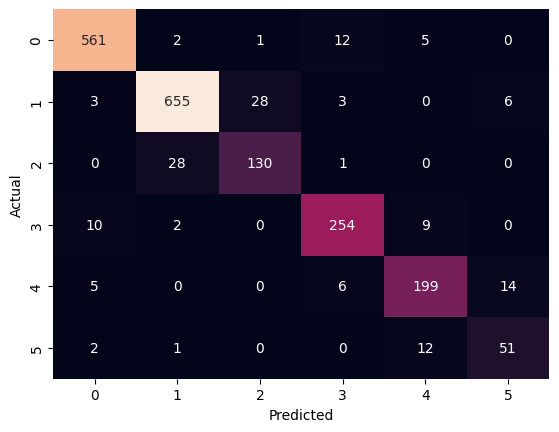

In [ ]:
# Fine tuned on all layers with best BERT params (Fine tune on all layers)
batch_size = 128
epochs = 3
lr = 1e-5
weight_decay = 0.01


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_eval = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

bert = Bert(fine_tune_last_layers=False)
bert.fit(train_loader, epochs, lr, weight_decay)
y_pred = bert.predict(test_loader)


print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('./out/all_layers_confmatrix.png', dpi=400)
plt.show()

Training Epoch 1: 100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


  Average training loss: 0.05452223039418459


Training Epoch 2: 100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


  Average training loss: 0.05225485884398222


Training Epoch 3: 100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


  Average training loss: 0.053973456226289275
              precision    recall  f1-score   support

           0     0.9656    0.9656    0.9656       581
           1     0.9481    0.9453    0.9467       695
           2     0.8187    0.8239    0.8213       159
           3     0.9396    0.9055    0.9222       275
           4     0.8661    0.9241    0.8942       224
           5     0.7742    0.7273    0.7500        66

    accuracy                         0.9265      2000
   macro avg     0.8854    0.8819    0.8833      2000
weighted avg     0.9268    0.9265    0.9265      2000



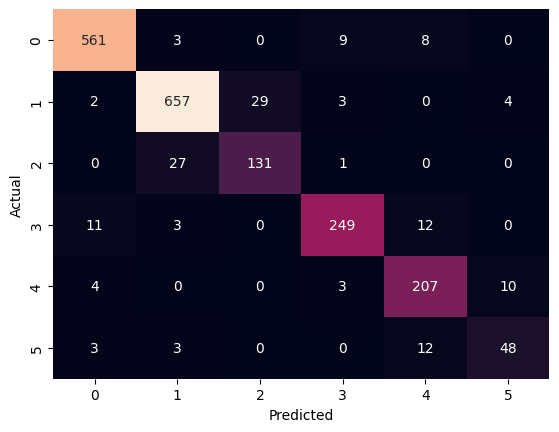

In [ ]:
# Fine tuned on final layers with best BERT params (Fine tune on last layer)
batch_size = 128
epochs = 3
lr = 2e-5
weight_decay = 0.01


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_eval = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

bert = Bert(fine_tune_last_layers=True)
bert.fit(train_loader, epochs, lr, weight_decay)
y_pred = bert.predict(test_loader)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('./out/final_layers_confmatrix.png', dpi=400)
plt.show()

              precision    recall  f1-score   support

           0     0.9689    0.9639    0.9664       581
           1     0.9415    0.9496    0.9456       695
           2     0.8400    0.7925    0.8155       159
           3     0.9398    0.9091    0.9242       275
           4     0.8636    0.9330    0.8970       224
           5     0.7619    0.7273    0.7442        66

    accuracy                         0.9265      2000
   macro avg     0.8860    0.8792    0.8821      2000
weighted avg     0.9265    0.9265    0.9262      2000



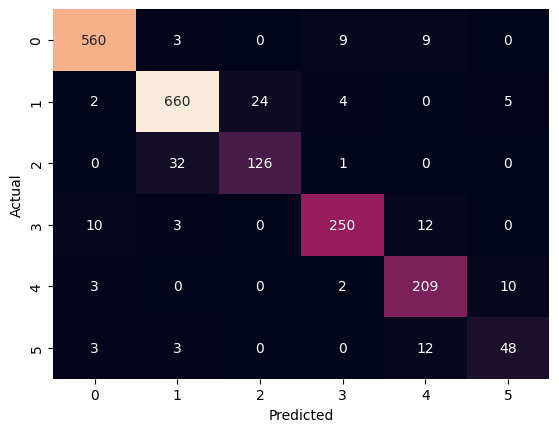

In [ ]:
# BERT original model
batch_size = 128

test_loader = DataLoader(test_dataset, batch_size=batch_size)

bert = Bert()
y_pred = bert.predict(test_loader)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig('./out/base_model_confmatrix.png', dpi=400)
plt.show()